In [1]:
#analytics
import pandas as pd
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from entropy_python_library.entropy.entropy import *
import mass_ts as mts

import stumpy
# visuals
import matplotlib.pyplot as plt

/Users/tortysivill/.pyenv/versions/3.7.3/envs/entropy/lib/python3.7/site-packages/mass_ts/_mass_ts.py:18: UserWarning: GPU support will not work. You must pip install mass-ts[gpu].
  'GPU support will not work. You must pip install mass-ts[gpu].')


In [2]:
import complexityparameters

## Import Condition Data

In [3]:
path = "data/useful/depresjon/"

In [4]:
    
condition = [pd.read_csv(f,header=0, index_col=0, parse_dates=True, squeeze=True) for f in glob.glob(path + "data/condition/*.csv")]
control = [pd.read_csv(f,header=0, index_col=0, parse_dates=True, squeeze=True) for f in glob.glob(path + "data/control/*.csv")]

## Import Control Data

### Extracting the following features from selected data

<ol>
<li>Mean Activity Level</li>
<li>Standard Deviation</li>
<li> Trimmed Mean </li>
</ol>

In [5]:

# separate into condition and control lists
x = np.zeros(23)
y = np.ones(len(control))
index = np.hstack((x,y))
df_scores = pd.read_csv(path + 'data/scores.csv')
df_scores['group'] = index

split_scores_control = list(df_scores.groupby('group'))[1]
split_scores_condition = list(df_scores.groupby('group'))[0]

# Clean data to only include the first n days of data records
limited_control = [list(x.groupby('date'))[0:y] for x, y in zip(control,split_scores_control[1]['days'])]
limited_condition =[list(x.groupby('date'))[0:y] for x, y in zip(condition,split_scores_condition[1]['days'])]

untupled_list = []
for y in limited_control:
    untupled_list.append([x[1] for x in y])
limited_control_df = [pd.concat(x) for x in untupled_list]

untupled_list = []
for y in limited_condition:
    untupled_list.append([x[1] for x in y])
limited_condition_df = [pd.concat(x) for x in untupled_list]

In [6]:

training_data_raw = [x['activity'].values for x in limited_condition_df] + [x['activity'].values for x in limited_control_df]

In [7]:
def normalise(X):
    return [(x - min(X))/(max(X)-min(X)) for x in X]

In [8]:
y = np.asarray([1 for x in range(0,len(condition))] + [0 for x in range(0,len(control))])


In [9]:
control_auto = [x['activity'].values for x in control]
condition_auto = [x['activity'].values for x in condition]

## Aggregate Features

## Parameter Suite

In [10]:
normalised_complexity_feature_df = complexityparameters.normalised_complexity_features(training_data_raw)

In [11]:
normalised_summary_feature_df = complexityparameters.normalised_summary_features(training_data_raw)

In [12]:
normalised_all_feature_df = complexityparameters.normalised_all_features(training_data_raw)

In [13]:
normalised_summary_feature_df['mean'] = normalise([np.mean(instance) for instance in training_data_raw])
normalised_summary_feature_df['std'] = normalise([np.std(instance) for instance in training_data_raw])


In [14]:
lubba_training_data = [list(instance) for instance in training_data_raw]

In [15]:
normalised_lubba_df = complexityparameters.normalised_lubba_features(lubba_training_data)

AttributeError: module 'complexityparameters' has no attribute 'normalised_lubba_features'

### Models 

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


classifiers = [
    KNeighborsClassifier(1),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


### results from lubba

In [17]:
from sklearn.ensemble import RandomForestClassifier

temp_summary_feature_df = normalised_lubba_df.copy()

rfc = RandomForestClassifier()
X = temp_summary_feature_df.dropna(axis='columns').values
accuracy_scores = []
precision_scores = []
recall_scores = []
F1_scores = []

accuracy_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='accuracy'))
precision_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='precision_weighted'))
recall_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='recall_weighted'))
F1_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='f1_weighted'))

print(np.mean(accuracy_scores,axis=1))
print(np.mean(precision_scores,axis=1))
print(np.mean(recall_scores,axis=1))
print(np.mean(F1_scores,axis=1))


print(np.std(accuracy_scores,axis=1))
print(np.std(precision_scores,axis=1))
print(np.std(recall_scores,axis=1))
print(np.std(F1_scores,axis=1))


NameError: name 'normalised_lubba_df' is not defined

### results from each complexity parameter and all summary features

In [18]:
from sklearn.ensemble import RandomForestClassifier

temp_summary_feature_df = normalised_summary_feature_df.copy()

rfc = RandomForestClassifier()
for column in normalised_complexity_feature_df:
    temp_summary_feature_df['complexity_feature'] = normalised_complexity_feature_df[[column]]
    X = temp_summary_feature_df.dropna(axis='columns').values
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    F1_scores = []

    accuracy_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='accuracy'))
    precision_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='precision_weighted'))
    recall_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='recall_weighted'))
    F1_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='f1_weighted'))

    print(column)
    print(np.mean(accuracy_scores,axis=1))
    print(np.mean(precision_scores,axis=1))
    print(np.mean(recall_scores,axis=1))
    print(np.mean(F1_scores,axis=1))


    print(np.std(accuracy_scores,axis=1))
    print(np.std(precision_scores,axis=1))
    print(np.std(recall_scores,axis=1))
    print(np.std(F1_scores,axis=1))


lempel_ziv
[0.7]
[0.62211111]
[0.66333333]
[0.70785714]
[0.20439613]
[0.28428129]
[0.22874051]
[0.22074921]
approx
[0.71666667]
[0.69044444]
[0.74]
[0.67481481]
[0.20179748]
[0.30720442]
[0.17938165]
[0.25401369]
sample
[0.65]
[0.64711111]
[0.70333333]
[0.6832672]
[0.19336207]
[0.22202169]
[0.21931712]
[0.22121692]
permutation
[0.77666667]
[0.73961111]
[0.74333333]
[0.72571429]
[0.18740924]
[0.22571095]
[0.17387735]
[0.1919845]
spectral
[0.68333333]
[0.74944444]
[0.70333333]
[0.60940476]
[0.17841898]
[0.24207437]
[0.17916473]
[0.23286058]
skewness
[0.72]
[0.66322222]
[0.71666667]
[0.68880952]
[0.22221111]
[0.2377083]
[0.20776589]
[0.2386946]
kurtosis
[0.71666667]
[0.69294444]
[0.71666667]
[0.63702381]
[0.22766935]
[0.2612326]
[0.20179748]
[0.17622462]
SVD
[0.77666667]
[0.66377778]
[0.72]
[0.68559524]
[0.18740924]
[0.20385434]
[0.15930404]
[0.18329812]


### results from all complexity parameters and mean,std

### Results from ALL features

In [18]:
from sklearn.ensemble import RandomForestClassifier

temp_all_feature_df = normalised_all_feature_df.copy()
temp_all_feature_df['mean'] = normalise([np.mean(instance) for instance in training_data_raw])
temp_all_feature_df['std'] = normalise([np.std(instance) for instance in training_data_raw])

X = temp_all_feature_df.dropna(axis='columns').values

print(rfc)
accuracy_scores = []
precision_scores = []
recall_scores = []
F1_scores = []

rfc = DecisionTreeClassifier()
accuracy_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='accuracy'))
precision_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='precision_weighted'))
recall_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='recall_weighted'))
F1_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='f1_weighted'))

print(np.mean(accuracy_scores,axis=1))
print(np.mean(precision_scores,axis=1))
print(np.mean(recall_scores,axis=1))
print(np.mean(F1_scores,axis=1))


print(np.std(accuracy_scores,axis=1))
print(np.std(precision_scores,axis=1))
print(np.std(recall_scores,axis=1))
print(np.std(F1_scores,axis=1))


DecisionTreeClassifier()
[0.6]
[0.6375]
[0.59666667]
[0.51587302]
[0.22949219]
[0.22233764]
[0.25317978]
[0.23890339]


### Dont want all features - curse of dimensionality and not very intepretable - lets try and think more about our features

In [27]:
import seaborn as sn

#### lets plot correlation for the complexity features

In [92]:
corrMatrix = normalised_complexity_feature_df.corr()

#### visualise correlation matrix

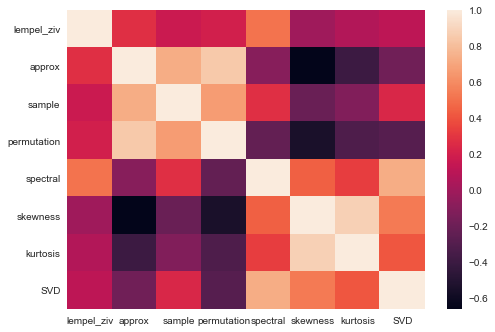

In [93]:
sn.heatmap(corrMatrix, annot=False)
plt.show()

In [47]:
### lets plot correlation for the summary features (first half)

In [48]:
corrMatrix = normalised_summary_feature_df.iloc[:, 0:10].corr()

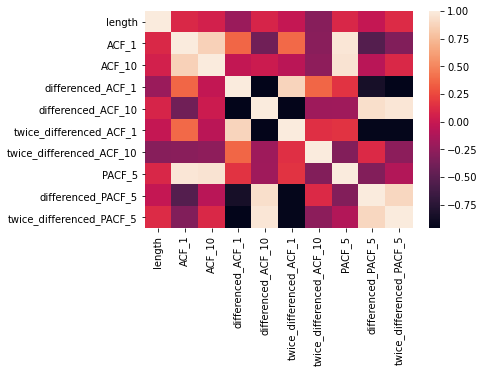

In [49]:
sn.heatmap(corrMatrix, annot=False)
plt.show()

#### lets plot correlation for the summary features (second half)

In [44]:
corrMatrix = normalised_summary_feature_df.iloc[:, 10:].corr()

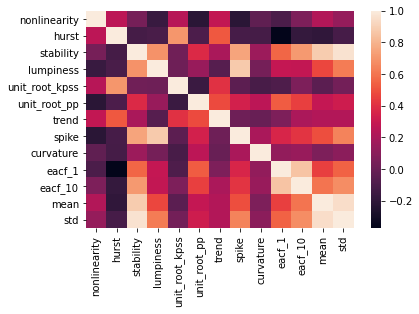

In [45]:
sn.heatmap(corrMatrix, annot=False)
plt.show()

In [ ]:
#### lets plot correlation for the summary features (second half)

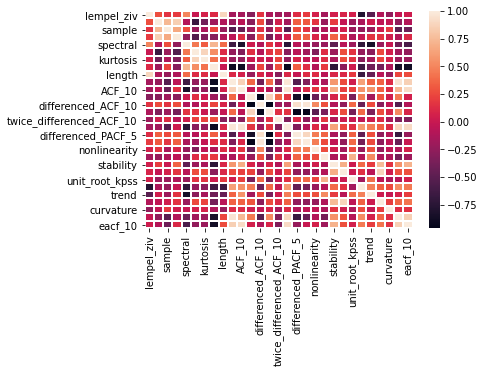

In [42]:
corrMatrix = normalised_all_feature_df.corr()
sn.heatmap(corrMatrix, annot=False, linewidths=1.)
plt.savefig('correlation_matrix.eps')
plt.show()

### Feature Importances

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

model = RandomForestClassifier().fit(X_train, y_train)
print(model.score(X_val, y_val))

### Permutation Feature Importance

In [55]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model, X_val, y_val,n_repeats=30,random_state=0)

Depresjon_feature_names = temp_all_feature_df.dropna(axis='columns').columns
for i in r.importances_mean.argsort()[::-1]:
    print(f"{Depresjon_feature_names[i]:<8}"f"{r.importances_mean[i]:.3f}"f" +/- {r.importances_std[i]:.3f}")

permutation0.110 +/- 0.060
unit_root_kpss0.076 +/- 0.032
mean    0.057 +/- 0.029
spike   0.048 +/- 0.034
trend   0.045 +/- 0.034
SVD     0.038 +/- 0.036
skewness0.038 +/- 0.036
approx  0.021 +/- 0.033
twice_differenced_ACF_10.019 +/- 0.032
stability0.017 +/- 0.030
ACF_1   0.017 +/- 0.030
eacf_1  0.012 +/- 0.027
curvature0.005 +/- 0.018
ACF_10  0.000 +/- 0.000
kurtosis0.000 +/- 0.000
sample  0.000 +/- 0.000
length  0.000 +/- 0.000
std     0.000 +/- 0.000
twice_differenced_ACF_100.000 +/- 0.000
differenced_ACF_10.000 +/- 0.000
differenced_ACF_100.000 +/- 0.000
PACF_5  0.000 +/- 0.000
differenced_PACF_50.000 +/- 0.000
twice_differenced_PACF_50.000 +/- 0.000
nonlinearity0.000 +/- 0.000
lumpiness0.000 +/- 0.000
unit_root_pp0.000 +/- 0.000
lempel_ziv0.000 +/- 0.000
eacf_10 -0.014 +/- 0.047
spectral-0.086 +/- 0.047


### LIME

21-Feb-24 11:57:53 fatf.transparency.predictions.surrogate_explainers INFO     Selecting 30 features with highest weights.


{'condition': {'0.71 < *lempel_ziv* <= 0.81': -0.01365058803009141, '0.68 < *approx* <= 0.77': -0.01884955473235169, '*sample* <= 0.22': 0.018822270548560675, '0.68 < *permutation* <= 0.81': 0.015685894421852385, '0.39 < *spectral* <= 0.58': 0.0849859542853453, '0.14 < *skewness* <= 0.29': -0.008825958379359239, '0.06 < *kurtosis* <= 0.12': -0.051809488603302846, '0.37 < *SVD* <= 0.47': -0.009401976711966253, '0.71 < *length* <= 0.73': -0.05889522332958389, '0.65 < *ACF_1* <= 0.76': 0.025840490814976996, '0.50 < *ACF_10* <= 0.54': 0.0042838942341734045, '0.39 < *differenced_ACF_1* <= 0.60': 0.015316312693049849, '0.42 < *differenced_ACF_10* <= 0.57': 0.046276252962518825, '0.44 < *twice_differenced_ACF_1* <= 0.55': 0.03417266352793788, '0.41 < *twice_differenced_ACF_10* <= 0.51': 0.009765302321649624, '0.63 < *PACF_5* <= 0.72': -0.017212466800267112, '0.46 < *differenced_PACF_5* <= 0.57': -0.008666240173177733, '0.47 < *twice_differenced_PACF_5* <= 0.59': -0.008668863336631454, '0.53 <

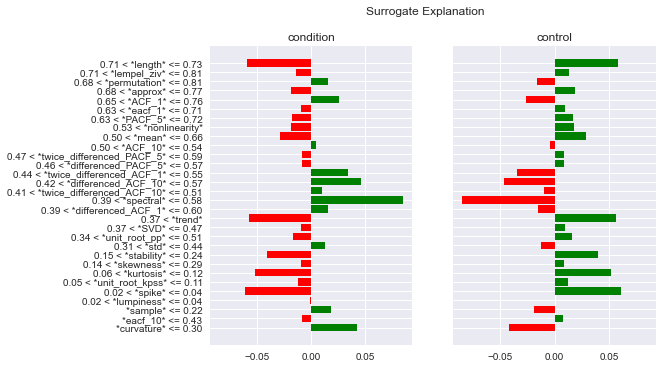

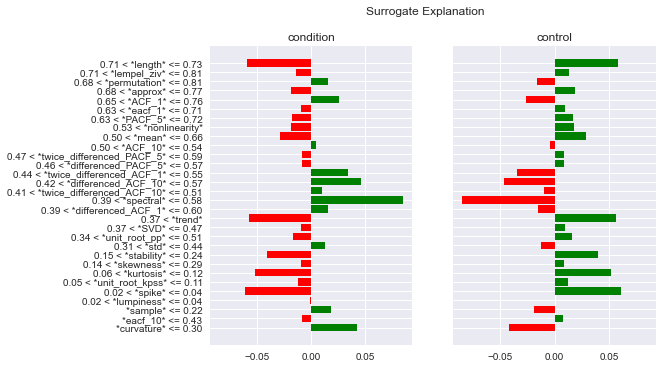

In [61]:
import fatf.transparency.predictions.surrogate_explainers as fatf_surrogates
import fatf.vis.lime as fatf_vis_lime

Depresjon_class_names = ['condition','control']
lime = fatf_surrogates.TabularBlimeyLime(
    X_train,
    model,
    feature_names=list(Depresjon_feature_names),
    class_names=Depresjon_class_names)

# Choose an index of the instance to be explained
index_to_explain = 0

# Explain an instance
lime_explanation = lime.explain_instance(
    X_train[index_to_explain, :], samples_number=50)

# Display the textual explanation
print(lime_explanation)

# Plot the explanation
fatf_vis_lime.plot_lime(lime_explanation)

In [ ]:
### SHAP

Index(['lempel_ziv', 'approx', 'sample', 'permutation', 'spectral', 'skewness',
       'kurtosis', 'SVD', 'length', 'ACF_1', 'ACF_10', 'differenced_ACF_1',
       'differenced_ACF_10', 'twice_differenced_ACF_1',
       'twice_differenced_ACF_10', 'PACF_5', 'differenced_PACF_5',
       'twice_differenced_PACF_5', 'nonlinearity', 'stability', 'lumpiness',
       'unit_root_kpss', 'unit_root_pp', 'trend', 'spike', 'curvature',
       'eacf_1', 'eacf_10', 'mean', 'std'],
      dtype='object')


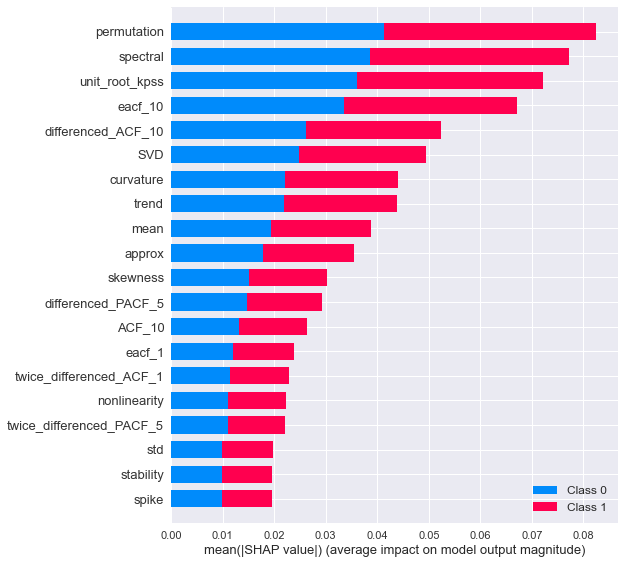

In [108]:
import shap
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
print(Depresjon_feature_names)
shap.summary_plot(shap_values, X_train, Depresjon_feature_names)

In [49]:
### Find the top 5 summary features

temp_all_feature_df = normalised_all_feature_df.copy()

X = temp_all_feature_df.dropna(axis='columns').values
y = np.asarray([1 for x in range(0,len(condition))] + [0 for x in range(0,len(control))])


model = RandomForestClassifier().fit(X, y)

In [59]:
import shap
shap.initjs()

model = RandomForestClassifier().fit(X, y)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
summary_Depresjon_feature_names = temp_all_feature_df.dropna(axis='columns').columns
shap.summary_plot(shap_values, X, summary_Depresjon_feature_names)
plt.close()

### Top 5 Summary and Complexity

In [ ]:
#### Permutation Entropy

In [36]:
from sklearn.ensemble import RandomForestClassifier

temp_summary_feature_df = normalised_summary_feature_df.copy()


temp_summary_feature_df['complexity_feature'] = normalised_complexity_feature_df[['permutation']]
# top 5 features
X = temp_summary_feature_df[['complexity_feature', 'trend', 'unit_root_kpss', 'mean', 'eacf_10', 'std']].values
#top 10 features
#X = temp_summary_feature_df[['complexity_feature', 'trend', 'unit_root_kpss', 'mean', 'eacf_10', 'std', 'ACF_10', 'curvature', 'twice_differenced_ACF_10', 'stability', 'spike']].values

accuracy_scores = []
precision_scores = []
recall_scores = []
F1_scores = []

rfc = RandomForestClassifier()
accuracy_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='accuracy'))
precision_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='precision_weighted'))
recall_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='recall_weighted'))
F1_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='f1_weighted'))

print(np.mean(accuracy_scores,axis=1))
print(np.mean(precision_scores,axis=1))
print(np.mean(recall_scores,axis=1))
print(np.mean(F1_scores,axis=1))


print(np.std(accuracy_scores,axis=1))
print(np.std(precision_scores,axis=1))
print(np.std(recall_scores,axis=1))
print(np.std(F1_scores,axis=1))

[0.81333333]
[0.72444444]
[0.79666667]
[0.76]
[0.16546232]
[0.27078076]
[0.15380363]
[0.20838652]


In [116]:
from sklearn.ensemble import RandomForestClassifier

temp_summary_feature_df = normalised_summary_feature_df.copy()


temp_summary_feature_df['complexity_feature'] = normalised_complexity_feature_df[['spectral']]
# top 5 features
X = temp_summary_feature_df[['complexity_feature', 'trend', 'unit_root_kpss', 'mean', 'eacf_10', 'std']].values
# top 10 features
X = temp_summary_feature_df[['complexity_feature', 'trend', 'unit_root_kpss', 'mean', 'eacf_10', 'std', 'ACF_10', 'curvature', 'twice_differenced_ACF_10', 'stability', 'spike']].values
accuracy_scores = []
precision_scores = []
recall_scores = []
F1_scores = []

rfc = RandomForestClassifier()
accuracy_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='accuracy'))
precision_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='precision_weighted'))
recall_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='recall_weighted'))
F1_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='f1_weighted'))

print(np.mean(accuracy_scores,axis=1))
print(np.mean(precision_scores,axis=1))
print(np.mean(recall_scores,axis=1))
print(np.mean(F1_scores,axis=1))


print(np.std(accuracy_scores,axis=1))
print(np.std(precision_scores,axis=1))
print(np.std(recall_scores,axis=1))
print(np.std(F1_scores,axis=1))

[0.75666667]
[0.83083333]
[0.77333333]
[0.82207672]
[0.20819329]
[0.13038671]
[0.23084386]
[0.20647844]


In [ ]:
## Both

In [118]:
from sklearn.ensemble import RandomForestClassifier

temp_summary_feature_df = normalised_summary_feature_df.copy()


temp_summary_feature_df['permutation_feature'] = normalised_complexity_feature_df[['permutation']]
temp_summary_feature_df['spectral_feature'] = normalised_complexity_feature_df[['spectral']]
# top 5
X = temp_summary_feature_df[['permutation_feature','spectral_feature','trend', 'unit_root_kpss', 'mean', 'eacf_10', 'std']].values
# top 10 
X = temp_summary_feature_df[['permutation_feature', 'spectral_feature', 'trend', 'unit_root_kpss', 'mean', 'eacf_10', 'std', 'ACF_10', 'curvature', 'twice_differenced_ACF_10', 'stability', 'spike']].values


accuracy_scores = []
precision_scores = []
recall_scores = []
F1_scores = []

rfc = RandomForestClassifier()
accuracy_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='accuracy'))
precision_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='precision_weighted'))
recall_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='recall_weighted'))
F1_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='f1_weighted'))

print(np.mean(accuracy_scores,axis=1))
print(np.mean(precision_scores,axis=1))
print(np.mean(recall_scores,axis=1))
print(np.mean(F1_scores,axis=1))


print(np.std(accuracy_scores,axis=1))
print(np.std(precision_scores,axis=1))
print(np.std(recall_scores,axis=1))
print(np.std(F1_scores,axis=1))

[0.76333333]
[0.81694444]
[0.72666667]
[0.67488095]
[0.14177447]
[0.19278838]
[0.15549205]
[0.16601783]


In [49]:
temp_summary_feature_df = normalised_summary_feature_df.copy()

X = temp_summary_feature_df.dropna(axis='columns')
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=0)

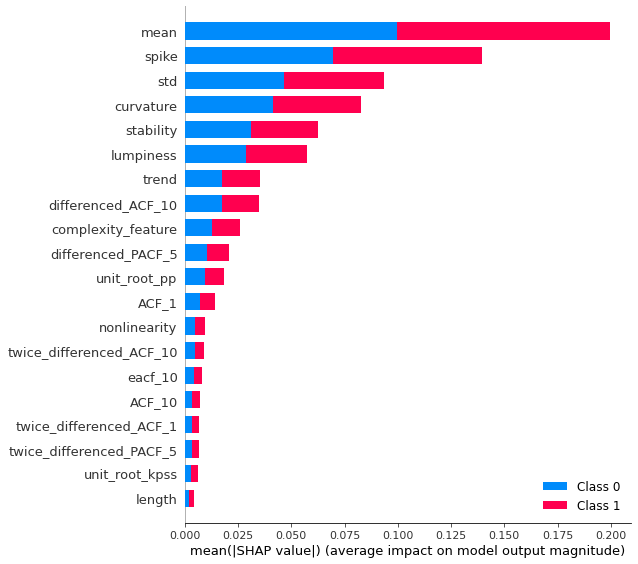

In [22]:
import shap
shap.initjs()

model = RandomForestClassifier().fit(X_val.values, y_val)
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val.values)
shap.summary_plot(shap_values, X_val.values, normalised_summary_feature_df.dropna(axis='columns').columns )

In [50]:

X_selected = X_train[['complexity_feature','mean','spike','std','curvature']]


rfc = RandomForestClassifier()

accuracy_scores = []
precision_scores = []
recall_scores = []
F1_scores = []


accuracy_scores.append(cross_val_score(rfc, X_selected, y_train, cv=10, scoring='accuracy'))
precision_scores.append(cross_val_score(rfc, X_selected, y_train, cv=10, scoring='precision_weighted'))
recall_scores.append(cross_val_score(rfc, X_selected, y_train, cv=10, scoring='recall_weighted'))
F1_scores.append(cross_val_score(rfc, X_selected, y_train, cv=10, scoring='f1_weighted'))


print(np.mean(accuracy_scores,axis=1))
print(np.mean(precision_scores,axis=1))
print(np.mean(recall_scores,axis=1))
print(np.mean(F1_scores,axis=1))


print(np.std(accuracy_scores,axis=1))
print(np.std(precision_scores,axis=1))
print(np.std(recall_scores,axis=1))
print(np.std(F1_scores,axis=1))

[0.77]
[0.74766667]
[0.76666667]
[0.725]
[0.19232496]
[0.26116002]
[0.21705094]
[0.27511129]


### My Features

In [19]:
def DP_entropy(x,window): 
    bins = 2
    time_series = np.array(x,dtype=float)
    matrix_profile = stumpy.stump(time_series, m=window)
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    distance_sum = np.sum(df_matrix_profile['distances'])
    total = len(df_matrix_profile['distances'])
    categorical_object = pd.cut(df_matrix_profile['distances'], bins)
    counts = []
    for bini in range(0,bins):
        counts.append(categorical_object.value_counts().values[bini]/total)
    entropy = -np.sum([(x)*np.log(x) for x in counts])
    return entropy

In [20]:
from scipy import signal

def DP_flatness_motif(x,window):
    time_series = np.array(x,dtype=float)
    my_window = len(time_series) - window
    window_size = window # Approximately, how many data points might be found in a pattern
    matrix_profile = stumpy.stump(time_series, m=window_size)
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['indexes']= df_matrix_profile.index
    top_motifs = df_matrix_profile.sort_values(by='distances')[0:10]
    distance_sum = np.sum(top_motifs['distances'])
    entropy_sum = np.sum([np.log(x) for x in top_motifs['distances']])
    entropy = entropy_sum * 1/len(top_motifs['distances'])
    entropy = np.exp(entropy)
    #entropy = entropy/(distance_sum/len(top_motifs['distances']))
    return entropy

In [21]:
from scipy import signal

def DP_flatness(x,window):
    time_series = np.array(x,dtype=float)
    my_window = len(time_series) - window
    window_size = window # Approximately, how many data points might be found in a pattern
    matrix_profile = stumpy.stump(time_series, m=window_size)
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['indexes']= df_matrix_profile.index
    top_motifs = df_matrix_profile.sort_values(by='distances')
    distance_sum = np.sum(df_matrix_profile['distances'])
    entropy_sum = np.sum([np.log(x) for x in df_matrix_profile['distances']])
    entropy = entropy_sum * 1/len(df_matrix_profile['distances'])
    entropy = np.exp(entropy)
    entropy = entropy/(distance_sum/len(df_matrix_profile['distances']))
    return entropy

In [22]:
def sequential_entropy(x,window):
    yes = 0
    time_series = np.array(x,dtype=float)
    window_size = window # Approximately, how many data points might be found in a pattern
    matrix_profile = stumpy.stump(time_series, m=window_size)
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['left_index']= matrix_profile[:,1]
    a_s = len(df_matrix_profile.index)
    for x in range(0,len(df_matrix_profile.index)-1):
        if df_matrix_profile['left_index'].iloc[x+1] == df_matrix_profile['left_index'].iloc[x] + 1:
            yes = yes + 1
    return np.log(a_s) - np.log(yes)

In [23]:
from scipy.stats import skew
from scipy.stats import kurtosis

def get_features(window, feature):
    entropy_feature = []
    
    
    for x in training_data_raw:
        if feature == 0:
            entropy_feature.append(DP_entropy(x, window))
        elif feature == 1:
            entropy_feature.append(DP_flatness(x, window))
        elif feature == 2:
            entropy_feature.append(sequential_entropy(x, window))
        elif feature == 3:
            entropy_feature.append(DP_flatness_motif(x,window))
    
    temp_summary_feature_df = normalised_summary_feature_df.copy()
    return normalise(entropy_feature)
   #return(temp_summary_feature_df[['complexity_feature', 'mean', 'std']].values)


In [24]:
from scipy.stats import skew
from scipy.stats import kurtosis

def features(window, feature):
    entropy_feature = []
    
    
    for x in training_data_raw:
        if feature == 0:
            entropy_feature.append(DP_entropy(x, window))
        elif feature == 1:
            entropy_feature.append(DP_flatness(x, window))
        elif feature == 2:
            entropy_feature.append(sequential_entropy(x, window))
        elif feature == 3:
            entropy_feature.append(DP_flatness_motif(x,window))
    
    temp_summary_feature_df = normalised_summary_feature_df.copy()
    temp_summary_feature_df['complexity_feature'] = normalise(entropy_feature)
    #return(temp_summary_feature_df[['complexity_feature', 'trend', 'unit_root_kpss', 'mean', 'eacf_10', 'std']].values)
    return(temp_summary_feature_df.dropna(axis='columns').values)



In [25]:
## Results for DP Entropy

In [37]:
import statsmodels.api as sm
y = np.asarray([1 for x in range(0,len(condition))] + [0 for x in range(0,len(control))])

from sklearn.ensemble import RandomForestClassifier


X = features(800,0) #2400 #up to 2500



rfc = RandomForestClassifier()
print(rfc)
accuracy_scores = []
precision_scores = []
recall_scores = []
F1_scores = []
accuracy_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='accuracy'))
precision_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='precision_weighted'))
recall_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='recall_weighted'))
F1_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='f1_weighted'))


print(np.mean(accuracy_scores,axis=1))
print(np.mean(precision_scores,axis=1))
print(np.mean(recall_scores,axis=1))
print(np.mean(F1_scores,axis=1))


print(np.std(accuracy_scores,axis=1))
print(np.std(precision_scores,axis=1))
print(np.std(recall_scores,axis=1))
print(np.std(F1_scores,axis=1))


RandomForestClassifier()
[0.71666667]
[0.65627778]
[0.69666667]
[0.71642857]
[0.2262005]
[0.28875703]
[0.24378953]
[0.24794038]


In [32]:
### Results for DP Flatness

In [38]:
import statsmodels.api as sm
y = np.asarray([1 for x in range(0,len(condition))] + [0 for x in range(0,len(control))])

from sklearn.ensemble import RandomForestClassifier


X = features(800,1) #2400 #up to 2500

   
rfc = RandomForestClassifier()
accuracy_scores = []
precision_scores = []
recall_scores = []
F1_scores = []


print(rfc)
accuracy_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='accuracy'))
precision_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='precision_weighted'))
recall_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='recall_weighted'))
F1_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='f1_weighted'))


print(np.mean(accuracy_scores,axis=1))
print(np.mean(precision_scores,axis=1))
print(np.mean(recall_scores,axis=1))
print(np.mean(F1_scores,axis=1))


print(np.std(accuracy_scores,axis=1))
print(np.std(precision_scores,axis=1))
print(np.std(recall_scores,axis=1))
print(np.std(F1_scores,axis=1))


RandomForestClassifier()
[0.66333333]
[0.641]
[0.68333333]
[0.64309524]
[0.21625602]
[0.27058804]
[0.23106036]
[0.24003602]


In [34]:
### Results for Sequential Entropy

In [39]:
import statsmodels.api as sm
y = np.asarray([1 for x in range(0,len(condition))] + [0 for x in range(0,len(control))])

from sklearn.ensemble import RandomForestClassifier

X = features(800,2) #2400 #up to 2500

    

rfc = RandomForestClassifier()
accuracy_scores = []
precision_scores = []
recall_scores = []
F1_scores = []


accuracy_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='accuracy'))
precision_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='precision_weighted'))
recall_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='recall_weighted'))
F1_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='f1_weighted'))


print(np.mean(accuracy_scores,axis=1))
print(np.mean(precision_scores,axis=1))
print(np.mean(recall_scores,axis=1))
print(np.mean(F1_scores,axis=1))


print(np.std(accuracy_scores,axis=1))
print(np.std(precision_scores,axis=1))
print(np.std(recall_scores,axis=1))
print(np.std(F1_scores,axis=1))


[0.66]
[0.63127778]
[0.71666667]
[0.65791005]
[0.21949437]
[0.272004]
[0.18752778]
[0.24554228]


In [ ]:
def calculate_DP(x):
    matrix_profile_A = stumpy.stump(x, m=100)
    matrix_profile_B = stumpy.stump(x, m=500)
    matrix_profile_C = stumpy.stump(x, m=1000)
    matrix_profile_D = stumpy.stump(x, m=1500)
    
    matrix_profiles = zip(matrix_profile_A, matrix_profile_B, matrix_profile_C, matrix_profile_D)

    distance_profile = []
    A_mean = np.mean(matrix_profile_A[:,0])
    B_mean = np.mean(matrix_profile_B[:,0])
    C_mean = np.mean(matrix_profile_C[:,0])
    D_mean= np.mean(matrix_profile_D[:,0])
    
    for A,B,C,D in matrix_profiles:
        A_vary = A_mean - A[0]
        B_vary = B_mean - B[0]
        C_vary = C_mean - C[0]
        D_vary = D_mean - D[0]
        distance_profile.append(np.max([A_vary, B_vary, C_vary, D_vary])**2)
    return(distance_profile)


In [83]:
from scipy import signal

def DP_split_flatness(x,window):
    time_series = np.array(x,dtype=float)
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= calculate_DP(time_series)
    #df_matrix_profile['indexes']= df_matrix_profile.index
    top_motifs = df_matrix_profile.sort_values(by='distances')[0:20]
    distance_sum = np.sum(top_motifs['distances'])
    entropy_sum = np.sum([np.log(x) for x in top_motifs['distances']])
    entropy = entropy_sum * 1/len(top_motifs['distances'])
    entropy = np.exp(entropy)
    return entropy

In [84]:
from scipy import signal

def DP_split_entropy(x,window):
    bins = 2
    time_series = np.array(x,dtype=float)
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= calculate_DP(time_series)
    #df_matrix_profile['indexes']= df_matrix_profile.index
    distance_sum = np.sum(df_matrix_profile['distances'])
    total = len(df_matrix_profile['distances'])
    df_matrix_profile.dropna()
    categorical_object = pd.cut(df_matrix_profile['distances'], bins)
    counts = []
    for bini in range(0,bins):
        counts.append(categorical_object.value_counts().values[bini]/total)
    entropy = -np.sum([(c)*np.log(c) for c in counts])
    return entropy
    return entropy

In [85]:
def calculate_DP_Sequential(x):
    matrix_profile_A = stumpy.stump(x, m=100)
    matrix_profile_B = stumpy.stump(x, m=500)
    matrix_profile_C = stumpy.stump(x, m=1000)
    matrix_profile_D = stumpy.stump(x, m=1500)

    matrix_profiles = zip(matrix_profile_A, matrix_profile_B, matrix_profile_C, matrix_profile_D)
    
    distance_profile = []
    A_mean = np.mean(matrix_profile_A[:,0])
    B_mean = np.mean(matrix_profile_B[:,0])
    C_mean = np.mean(matrix_profile_C[:,0])
    D_mean= np.mean(matrix_profile_D[:,0])
    
    for A,B,C,D in matrix_profiles:
        A_vary = A_mean - A[0]
        B_vary = B_mean - B[0]
        C_vary = C_mean - C[0]
        D_vary = D_mean - D[0]
        highest_index = np.argmax([A_vary, B_vary, C_vary, D_vary])
        if highest_index == 0:
            distance_profile.append(A[1])
        elif highest_index == 1:
            distance_profile.append(B[1])
        elif highest_index == 2:
            distance_profile.append(C[1])
        elif highest_index == 3:
            distance_profile.append(D[1]) 
    return(distance_profile)

In [86]:
def sequential_split_entropy(x,window):
    yes = 0
    time_series = np.array(x,dtype=float)
    window_size = window # Approximately, how many data points might be found in a pattern
    matrix_profile = stumpy.stump(time_series, m=window_size)
    neighbour_indexes = calculate_DP_Sequential(time_series)
  
    a_s = len(neighbour_indexes)
    for x in range(0,len(neighbour_indexes)-1):
        if neighbour_indexes[x+1] == neighbour_indexes[x] + 1:
            yes = yes + 1
    return np.log(a_s) - np.log(yes)

In [89]:
from scipy.stats import skew
from scipy.stats import kurtosis

def features2(window, feature):
    entropy_feature = []
    
    
    for x in training_data_raw:
        if feature == 0:
            entropy_feature.append(DP_split_entropy(x, window))
        elif feature == 1:
            entropy_feature.append(DP_split_flatness(x, window))
        elif feature == 2:
            entropy_feature.append(sequential_split_entropy(x, window))
    
    temp_summary_feature_df = normalised_summary_feature_df.copy()
    temp_summary_feature_df['complexity_feature'] = normalise(entropy_feature)
    return(temp_summary_feature_df[['complexity_feature', 'trend', 'unit_root_kpss', 'mean', 'std']].values)


In [90]:
import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier

X = features2(10,0) #2400 #up to 2500
rfc = RandomForestClassifier()
    

accuracy_scores = []
precision_scores = []
recall_scores = []
F1_scores = []


accuracy_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='accuracy'))
precision_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='precision_weighted'))
recall_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='recall_weighted'))
F1_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='f1_weighted'))


print(np.mean(accuracy_scores,axis=1))
print(np.mean(precision_scores,axis=1))
print(np.mean(recall_scores,axis=1))
print(np.mean(F1_scores,axis=1))


print(np.std(accuracy_scores,axis=1))
print(np.std(precision_scores,axis=1))
print(np.std(recall_scores,axis=1))
print(np.std(F1_scores,axis=1))


[0.79333333]
[0.79]
[0.76]
[0.76190476]
[0.21228911]
[0.18870579]
[0.18245243]
[0.17781746]


In [91]:
import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier

X = features2(10,1) #2400 #up to 2500
rfc = RandomForestClassifier()
    

accuracy_scores = []
precision_scores = []
recall_scores = []
F1_scores = []


accuracy_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='accuracy'))
precision_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='precision_weighted'))
recall_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='recall_weighted'))
F1_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='f1_weighted'))


print(np.mean(accuracy_scores,axis=1))
print(np.mean(precision_scores,axis=1))
print(np.mean(recall_scores,axis=1))
print(np.mean(F1_scores,axis=1))


print(np.std(accuracy_scores,axis=1))
print(np.std(precision_scores,axis=1))
print(np.std(recall_scores,axis=1))
print(np.std(F1_scores,axis=1))


[0.79333333]
[0.80166667]
[0.79333333]
[0.77619048]
[0.17751369]
[0.19978461]
[0.21228911]
[0.21070016]


In [92]:
import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier

X = features2(10,2) #2400 #up to 2500
rfc = RandomForestClassifier()
    

accuracy_scores = []
precision_scores = []
recall_scores = []
F1_scores = []


accuracy_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='accuracy'))
precision_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='precision_weighted'))
recall_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='recall_weighted'))
F1_scores.append(cross_val_score(rfc, X, y, cv=10, scoring='f1_weighted'))


print(np.mean(accuracy_scores,axis=1))
print(np.mean(precision_scores,axis=1))
print(np.mean(recall_scores,axis=1))
print(np.mean(F1_scores,axis=1))


print(np.std(accuracy_scores,axis=1))
print(np.std(precision_scores,axis=1))
print(np.std(recall_scores,axis=1))
print(np.std(F1_scores,axis=1))


[0.74]
[0.74777778]
[0.75666667]
[0.73904762]
[0.20805982]
[0.25423815]
[0.21962089]
[0.23943244]
